In [61]:
import torch
from torch import autograd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import cv2


In [62]:
in_height = 120
in_width = 120
in_channels = 3

In [63]:
##Divide ConvNet into multiple parts 
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [64]:
## conv layer (stem layer)
class _Stem(nn.Module): 
    def __init__(self):
        super(_Stem, self).__init__()
        self.stem = nn.Sequential(
                        BasicConv2d(in_channels, 64, kernel_size=7, padding=2, stride=2),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                        BasicConv2d(64, 64, kernel_size=1),
                        BasicConv2d(64, 192, kernel_size=3, padding=1),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                    )

    def forward(self, x):
        x = self.stem(x)

        return x


In [65]:
## auxiliary layer for vanishing gradient
class _Auxiliary_Classifiers(nn.Module):
    def __init__(self, num_fts):
        super(_Auxiliary_Classifiers, self).__init__()
        self.aux_classifier = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=5, stride=3, padding=2),
                                    BasicConv2d(num_fts, 128, kernel_size=1),
                                )

        self.classifier = nn.Sequential(
                                nn.Linear(5 * 5 * 128, 1024),
                                nn.Dropout(p=0.7),
                                nn.Linear(1024, 4)
                            )

    def forward(self, x):
        x = self.aux_classifier(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [66]:
class _Inception_Module(nn.Module):
    def __init__(self, conv1x1, conv1x1_reduce_3, conv1x1_reduce_5,
                        conv3x3, conv5x5, conv1x1_reduce_pool,
                        num_fts):
        super(_Inception_Module, self).__init__()

        self.conv1x1_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1, kernel_size=1),
                                )

        self.conv3x3_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1_reduce_3, kernel_size=1),
                                    BasicConv2d(conv1x1_reduce_3, conv3x3, kernel_size=3, padding=1),
                                )

        self.conv5x5_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1_reduce_5, kernel_size=1),
                                    BasicConv2d(conv1x1_reduce_5, conv5x5, kernel_size=5, padding=2),
                                )

        self.pool_branch = nn.Sequential(
                                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                    BasicConv2d(num_fts, conv1x1_reduce_pool, kernel_size=1),
                                )

    def forward(self, x):
        x1x1 = self.conv1x1_branch(x)
        x3x3 = self.conv3x3_branch(x)
        x5x5 = self.conv5x5_branch(x)
        xpool = self.pool_branch(x)

        x = torch.cat([x1x1, x3x3, x5x5, xpool], 1)

        return x 

In [67]:
class GoogleLeNet(nn.Module):
    def __init__(self):
        super(GoogleLeNet, self).__init__()
        self.features1 = nn.Sequential(
                            _Stem(),
                            _Inception_Module(conv1x1=64, conv1x1_reduce_3=96, conv3x3=128, 
                                conv1x1_reduce_5=16, conv5x5=32, conv1x1_reduce_pool=32, 
                                num_fts=192),
                            _Inception_Module(conv1x1=128, conv1x1_reduce_3=128, conv3x3=192, 
                                conv1x1_reduce_5=32, conv5x5=96, conv1x1_reduce_pool=64, 
                                num_fts=256),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                            _Inception_Module(conv1x1=192, conv1x1_reduce_3=96, conv3x3=208, 
                                conv1x1_reduce_5=16, conv5x5=48, conv1x1_reduce_pool=64, 
                                num_fts=480)
                        )

        self.features2 = nn.Sequential(
                            _Inception_Module(conv1x1=160, conv1x1_reduce_3=112, conv3x3=224, 
                                conv1x1_reduce_5=24, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512),
                            _Inception_Module(conv1x1=128, conv1x1_reduce_3=128, conv3x3=256, 
                                conv1x1_reduce_5=24, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512),
                            _Inception_Module(conv1x1=112, conv1x1_reduce_3=144, conv3x3=288, 
                                conv1x1_reduce_5=32, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512)
                        )

        self.features3 = nn.Sequential(
                            _Inception_Module(conv1x1=256, conv1x1_reduce_3=160, conv3x3=320, 
                                conv1x1_reduce_5=32, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=528),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                            _Inception_Module(conv1x1=256, conv1x1_reduce_3=160, conv3x3=320, 
                                conv1x1_reduce_5=32, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=832),
                            _Inception_Module(conv1x1=384, conv1x1_reduce_3=192, conv3x3=384, 
                                conv1x1_reduce_5=48, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=832)
                        )
        
        self.Aux1 = _Auxiliary_Classifiers(num_fts=512)
        self.Aux2 = _Auxiliary_Classifiers(num_fts=528)

        self.fc = nn.Linear(1024, 4)
    def forward(self, x):
        x = self.features1(x)

        if self.training:
            aux1 = self.Aux1(x)

        x = self.features2(x)

        if self.training:
            aux2 = self.Aux2(x)

        x = self.features3(x)
        x = F.avg_pool2d(x, kernel_size=7)
        x = x.view(-1 ,1024)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.fc(x)
        
        if self.training:
            return x, aux1, aux2
        else:
            return x

In [68]:
def train(model, criterion, optimizer, lr_scheduler, dsets_loader, dset_sizes, lr = 0.001, num_epochs = 20):
    since = time.time()
    use_model = model
    best_acc = 0.0
    #accuracy = []
    #epoch_num = []
    #loss_arr = []
    history = {
        x :[]
        for x in ['train','val']
    }
    
    for i in range(num_epochs):
        print('Epoch {}/{}'.format(i, num_epochs - 1))
        print('-'*10)
        for mode in ['train','val']:
            start = time.time()
            
            if mode == 'train':
                optimizer = lr_scheduler(optimizer, i, init_lr = lr)
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dsets_loader[mode]:
                
                inputs, labels = data
                #print(inputs)
                inputs_, labels_ = Variable(inputs.cuda()), Variable(labels.cuda())
                
                optimizer.zero_grad()
                
                
                
                if mode == 'train':
                    o1, o2, o3 = model(inputs_)
                    _, preds = torch.max(o1.data, 1)
                
                    loss1 = criterion(o1, labels_)
                    loss2 = criterion(o2, labels_)
                    loss3 = criterion(o3, labels_)

                    loss = loss1 + 0.3 * (loss2 + loss3)
                   
                else:
                    outputs = model(inputs_)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels_)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels_.data)
                
            epoch_loss = running_loss / dset_sizes[mode]
            #loss_arr.append(epoch_loss)
            epoch_acc = running_corrects / dset_sizes[mode]
            #accuracy.append(epoch_acc)
            epoch_time = time.time() - start
            
            history_dict =  {
                'mode':mode,
                'epoch':i,
                'epoch_loss': epoch_loss,
                'epoch_accuracy': epoch_acc,
                'learing_rate':optimizer.state_dict()['param_groups'][0]['lr']
                
            }
            
            history[mode].append(history_dict)
            
            print('{} Loss: {:.4f} Acc:{:.4f} Time: {:.0f}m {:.0f}s'.format(mode, epoch_loss, epoch_acc, epoch_time//60, epoch_time%60))
            
            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
    time_elapsed = time.time() - since
    
    print('Training completion in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best validation accuracy is {:.4f}'.format(best_acc))
    
    print('save mode')
    ##here I want to save the history of the process in order to debug
    with open('history.pickle','wb') as f:
        pickle.dump(history, f)
    
    return best_model, best_acc, history

In [69]:
#add scheduler to better control learning rate 
def exp_lr_scheduler(optimizer, epoch, init_lr = 0.001, lr_decay_epoch = 5):
    lr = init_lr * (0.9 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('Learning rate is changed to {}'.format(lr))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [70]:
net = GoogleLeNet().cuda()

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay = 0.0005)
lr_scheduler = exp_lr_scheduler
lr = 0.001

In [72]:
def load_data(train_path, val_path=None):
    if val_path is None:
        val_path = train_path
    train_transfrom = transforms.Compose([
        
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])

    val_transfrom = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])
    dsets = {
        'train': datasets.ImageFolder(train_path, train_transfrom),
        'val': datasets.ImageFolder(val_path, val_transfrom)
    }
    dset_loaders = {
        x: torch.utils.data.DataLoader(dsets[x], batch_size=7, shuffle=True, num_workers=4)
        for x in ['train', 'val']
    }
    dset_sizes = {
        x: len(dsets[x])
        for x in ['train', 'val']
    }
    
    dset_classes = dsets['train'].classes
    return dset_loaders, dset_sizes, dset_classes
        

    


In [73]:
train_file = './mri_imgs'
val_file = ''
##load data
#dset_loaders, dset_sizes, dset_classes = mri_loader.load_data(train_path=train_path, val_path=val_path)

In [74]:
dset_loaders, dset_sizes, dset_classes = load_data(train_path=train_file)

print(dset_sizes)
print(dset_classes)
print(dset_loaders)

{'train': 163, 'val': 163}
['label_0', 'label_1', 'label_2', 'label_3']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fdac5544d30>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fdac55448d0>}


In [75]:
best_model, best_acc, history = train(net, criterion, optimizer, lr_scheduler,
dset_loaders, dset_sizes, lr, 100)

Epoch 0/99
----------
Learning rate is changed to 0.001
train Loss: 0.3311 Acc:0.4417 Time: 0m 2s
val Loss: 0.3344 Acc:0.1350 Time: 0m 1s

Epoch 1/99
----------
train Loss: 0.2836 Acc:0.6012 Time: 0m 2s
val Loss: 0.1750 Acc:0.5337 Time: 0m 1s

Epoch 2/99
----------
train Loss: 0.2306 Acc:0.5706 Time: 0m 2s
val Loss: 0.1517 Acc:0.4908 Time: 0m 1s

Epoch 3/99
----------
train Loss: 0.1834 Acc:0.6933 Time: 0m 2s
val Loss: 0.0947 Acc:0.6810 Time: 0m 1s

Epoch 4/99
----------
train Loss: 0.2093 Acc:0.7055 Time: 0m 2s
val Loss: 0.6396 Acc:0.3006 Time: 0m 1s

Epoch 5/99
----------
Learning rate is changed to 0.0009000000000000001
train Loss: 0.2117 Acc:0.6564 Time: 0m 2s
val Loss: 0.1274 Acc:0.6994 Time: 0m 1s

Epoch 6/99
----------
train Loss: 0.1787 Acc:0.6564 Time: 0m 2s
val Loss: 0.0903 Acc:0.6933 Time: 0m 1s

Epoch 7/99
----------
train Loss: 0.1776 Acc:0.7055 Time: 0m 2s
val Loss: 0.0953 Acc:0.7117 Time: 0m 1s

Epoch 8/99
----------
train Loss: 0.1934 Acc:0.6319 Time: 0m 2s
val Loss: 0.

train Loss: 0.0034 Acc:1.0000 Time: 0m 2s
val Loss: 0.0002 Acc:1.0000 Time: 0m 1s

Epoch 72/99
----------
train Loss: 0.0017 Acc:1.0000 Time: 0m 2s
val Loss: 0.0003 Acc:1.0000 Time: 0m 1s

Epoch 73/99
----------
train Loss: 0.0147 Acc:0.9877 Time: 0m 2s
val Loss: 0.0001 Acc:1.0000 Time: 0m 1s

Epoch 74/99
----------
train Loss: 0.0030 Acc:1.0000 Time: 0m 2s
val Loss: 0.0003 Acc:1.0000 Time: 0m 1s

Epoch 75/99
----------
Learning rate is changed to 0.0002058911320946491
train Loss: 0.0114 Acc:0.9877 Time: 0m 2s
val Loss: 0.0001 Acc:1.0000 Time: 0m 1s

Epoch 76/99
----------
train Loss: 0.0102 Acc:0.9877 Time: 0m 2s
val Loss: 0.0002 Acc:1.0000 Time: 0m 1s

Epoch 77/99
----------
train Loss: 0.0035 Acc:1.0000 Time: 0m 2s
val Loss: 0.0002 Acc:1.0000 Time: 0m 1s

Epoch 78/99
----------
train Loss: 0.0028 Acc:1.0000 Time: 0m 2s
val Loss: 0.0001 Acc:1.0000 Time: 0m 1s

Epoch 79/99
----------
train Loss: 0.0017 Acc:1.0000 Time: 0m 2s
val Loss: 0.0001 Acc:1.0000 Time: 0m 1s

Epoch 80/99
-------

In [76]:
print(history)

{'train': [{'mode': 'train', 'epoch': 0, 'epoch_loss': 0.33110424272853173, 'epoch_accuracy': 0.44171779141104295, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 1, 'epoch_loss': 0.2835521844267114, 'epoch_accuracy': 0.6012269938650306, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 2, 'epoch_loss': 0.2306345682934018, 'epoch_accuracy': 0.5705521472392638, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 3, 'epoch_loss': 0.18339455712792332, 'epoch_accuracy': 0.6932515337423313, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 4, 'epoch_loss': 0.20933573469062525, 'epoch_accuracy': 0.7055214723926381, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 5, 'epoch_loss': 0.2116758816081322, 'epoch_accuracy': 0.656441717791411, 'learing_rate': 0.0009000000000000001}, {'mode': 'train', 'epoch': 6, 'epoch_loss': 0.1786854281747268, 'epoch_accuracy': 0.656441717791411, 'learing_rate': 0.0009000000000000001}, {'mode': 'train', 'epoch': 7, 'epoch_loss': 0.17762177579242028, 'epoch_a

In [77]:
train_epoch = []
train_loss = []
train_acc = []
learning_rate_used = []
for i in history['train']:
    train_epoch.append(i['epoch'])
    train_loss.append(i['epoch_loss'])
    train_acc.append(i['epoch_accuracy'])
    learning_rate_used.append(i['learing_rate'])
    

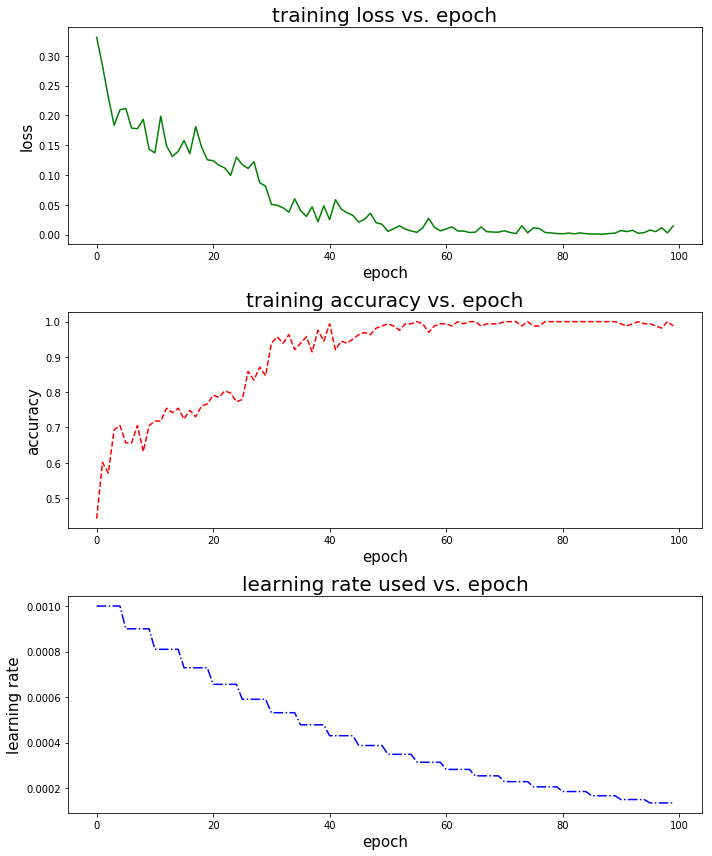

In [78]:
fig = plt.figure(figsize=(10, 12))

plt.subplot(311)
plt.plot(train_epoch, train_loss,'g-', linewidth = 1.5)
plt.title('training loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(312)
plt.plot(train_epoch, train_acc,'r--',linewidth = 1.5)
plt.title('training accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()
plt.subplot(313)
plt.plot(train_epoch, learning_rate_used,'b-.',linewidth = 1.5)
plt.title('learning rate used vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('learning rate', fontsize = 15)
plt.tight_layout()
fig.savefig('all_figures.png')

In [79]:
val_epoch = []
val_acc = []
val_loss = []
for i in history['val']:
    val_epoch.append(i['epoch'])
    val_loss.append(i['epoch_loss'])
    val_acc.append(i['epoch_accuracy'])
    

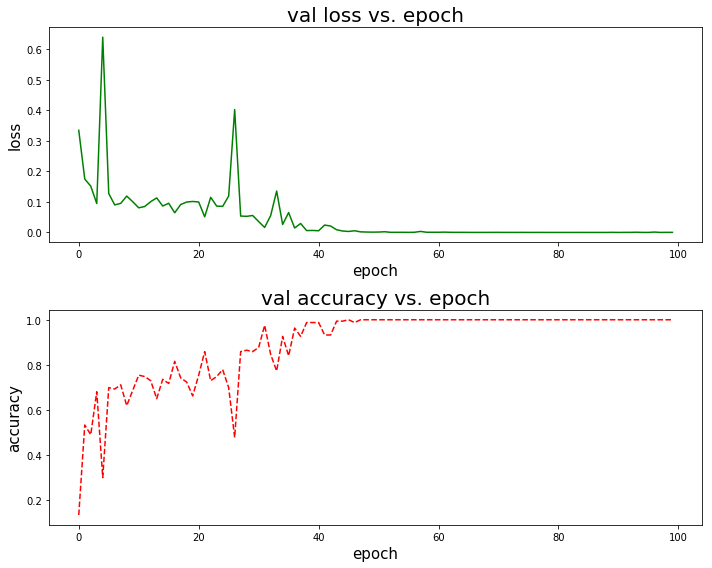

In [80]:
fig = plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.plot(val_epoch, val_loss,'g-',linewidth = 1.5)
plt.title('val loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(212)
plt.plot(val_epoch, val_acc,'r--',linewidth = 1.5)
plt.title('val accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()

fig.savefig('all_figures_val_gnet.png')

In [81]:
print(best_model)

GoogleLeNet (
  (features1): Sequential (
    (0): _Stem (
      (stem): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (1): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (2): BasicConv2d (
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (3): BasicConv2d (
          (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
        )
        (4): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      )
    )
    (1): _Inception_Module (
      (conv1x1_branch): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(192, 64, kernel_si

In [82]:
params = list(best_model.parameters())

In [83]:
for p in params:
    print(p.size())
    

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([192, 64, 3, 3])
torch.Size([192])
torch.Size([192])
torch.Size([64, 192, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([96, 192, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([128, 96, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([16, 192, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32, 192, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([192, 128, 3, 3])
torch.Size([192])
torch.Size([192])
torch.Size([32, 256, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([96, 32, 5, 5])
torch.Size([96])
torch.Size([96])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([192, 480, 1, 1])
torch.Size([192])
torch.Size([192

In [24]:
params[0]

Parameter containing:
(0 ,0 ,.,.) = 
  5.6522e-02  6.5610e-04  4.3719e-02  ...  -6.4740e-02 -8.7281e-02 -7.2087e-02
  7.6479e-02  3.8252e-02  6.9102e-02  ...  -2.9978e-02  1.5259e-02 -7.9955e-02
 -5.1793e-03 -7.6738e-02 -7.7098e-02  ...  -8.6123e-02  1.3653e-02 -1.2157e-02
                 ...                   ⋱                   ...                
  1.9400e-02  4.0444e-02 -3.6464e-02  ...  -3.9408e-02 -4.0201e-02 -7.4465e-02
 -7.2180e-02 -1.7445e-02  9.6061e-03  ...  -5.6608e-02  3.6513e-02  3.5392e-02
 -3.4363e-02 -7.3622e-02 -6.5614e-02  ...  -7.3597e-03 -7.6498e-02  6.2440e-02

(0 ,1 ,.,.) = 
 -1.9441e-02  5.7856e-02 -6.4618e-02  ...   1.2814e-02  5.7338e-02  4.2033e-02
 -5.9155e-02  2.9908e-02 -5.0730e-02  ...  -6.3139e-02  9.5886e-03 -1.2105e-02
  6.0754e-02  5.1734e-02 -1.5769e-02  ...  -6.2114e-02 -1.2748e-02 -2.7783e-04
                 ...                   ⋱                   ...                
  2.3954e-02  4.9932e-02 -6.5927e-02  ...  -1.8687e-02 -9.9619e-03 -3.8879e-03

In [25]:
count = 0

for m in best_model.modules():
    if isinstance(m, nn.Linear):
        count += 1
        if count == 5:
            print(m.weight.data)
            final_weight = m.weight.data.cpu().numpy()


 1.5122e-02 -2.6092e-02 -2.5943e-02  ...  -7.6151e-03 -3.2051e-02 -2.4884e-02
 2.3848e-02 -3.3314e-02  1.7902e-02  ...   2.2983e-02 -3.5320e-02 -3.1554e-02
-2.7002e-02  3.9717e-02 -1.3763e-02  ...  -1.5119e-02  1.9278e-02  2.4153e-02
[torch.cuda.FloatTensor of size 3x1024 (GPU 0)]



(3, 1024)


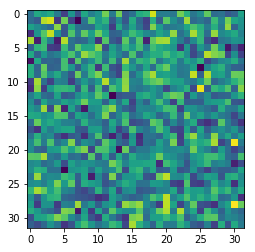

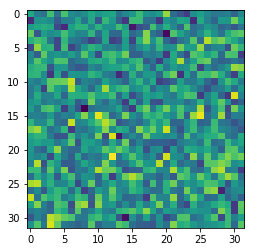

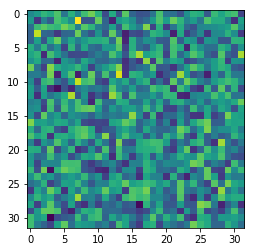

In [112]:
print(final_weight.shape)
plt.figure(1)
plt.imshow(final_weight[0,:].reshape(32,32))
plt.figure(2)
plt.imshow(final_weight[1,:].reshape(32,32))
plt.figure(3)
plt.imshow(final_weight[2,:].reshape(32,32))

In [26]:
print(best_model.modules)

<bound method Module.modules of GoogleLeNet (
  (features1): Sequential (
    (0): _Stem (
      (stem): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (1): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (2): BasicConv2d (
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (3): BasicConv2d (
          (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
        )
        (4): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      )
    )
    (1): _Inception_Module (
      (conv1x1_branch): Sequential (
        (0): BasicConv2d (
          (

In [84]:
val_transfrom = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])

In [85]:
from PIL import Image

In [86]:
test_img = Image.open('./mri_imgs/label_0/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.jpg')

In [87]:
print(test_img.size)

(176, 176)


In [88]:
img_to_use = val_transfrom(test_img)

In [89]:
img_to_use


( 0 ,.,.) = 
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
           ...             ⋱             ...          
 -2.0152 -1.9980 -1.9809  ...  -2.1008 -2.1179 -2.1179
 -1.9809 -1.9638 -1.9295  ...  -2.1008 -2.1179 -2.1179
 -1.9638 -1.9467 -1.9124  ...  -2.1008 -2.1179 -2.1179
[torch.FloatTensor of size 1x224x224]

In [90]:
new_img = img_to_use.numpy()

(1, 224, 224)


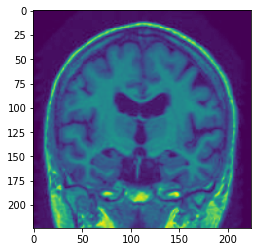

In [91]:
print(new_img.shape)
plt.imshow(new_img[0])

In [33]:
sd = best_model.state_dict()

In [31]:
for key, value in sd.items():
    print(key)

features1.0.stem.0.conv.weight
features1.0.stem.0.bn.weight
features1.0.stem.0.bn.bias
features1.0.stem.0.bn.running_mean
features1.0.stem.0.bn.running_var
features1.0.stem.2.conv.weight
features1.0.stem.2.bn.weight
features1.0.stem.2.bn.bias
features1.0.stem.2.bn.running_mean
features1.0.stem.2.bn.running_var
features1.0.stem.3.conv.weight
features1.0.stem.3.bn.weight
features1.0.stem.3.bn.bias
features1.0.stem.3.bn.running_mean
features1.0.stem.3.bn.running_var
features1.1.conv1x1_branch.0.conv.weight
features1.1.conv1x1_branch.0.bn.weight
features1.1.conv1x1_branch.0.bn.bias
features1.1.conv1x1_branch.0.bn.running_mean
features1.1.conv1x1_branch.0.bn.running_var
features1.1.conv3x3_branch.0.conv.weight
features1.1.conv3x3_branch.0.bn.weight
features1.1.conv3x3_branch.0.bn.bias
features1.1.conv3x3_branch.0.bn.running_mean
features1.1.conv3x3_branch.0.bn.running_var
features1.1.conv3x3_branch.1.conv.weight
features1.1.conv3x3_branch.1.bn.weight
features1.1.conv3x3_branch.1.bn.bias
fea

In [35]:
params[0][1]

Variable containing:
(0 ,.,.) = 
1.00000e-02 *
  -8.3639 -6.8963  5.0440  1.6571 -6.0828 -5.0083 -7.9698
  -8.4651  0.0109 -2.3543 -7.0746  4.9806  5.1598 -1.8584
  -0.6382 -2.2606  1.4104 -6.4806 -1.6392  4.9203 -3.5446
   2.0459 -0.2692 -3.0612  4.0141 -0.9626 -4.7924  3.0227
  -1.1420 -0.5830 -2.8491  4.6188 -7.3635 -3.1159  7.9916
   3.8289  7.5868  3.3698 -5.0133  5.8351  9.4384  4.0263
   6.6533  9.6733  3.2520  4.4351  6.8465 -0.7897  1.1419

(1 ,.,.) = 
1.00000e-02 *
   1.1955  0.4231 -0.8941  1.0049  2.7524  3.0165 -5.2661
  -7.1748  1.0516 -3.2741  5.0122 -3.9779  5.1753  1.8007
  -6.4735  2.0323  5.9323 -7.8229  3.7652 -4.3847  0.5800
   0.9324  5.8498  4.9334 -1.5156  0.8620 -1.9782  5.3362
   5.1149  6.2336 -8.0849  1.9879  4.2239  3.1289  6.9130
   0.1771  1.6349 -6.8430 -6.8321 -6.4354 -1.6176  0.8168
   8.6020 -0.9828 -4.8187 -5.0227  3.6283  9.8376  8.4312

(2 ,.,.) = 
1.00000e-02 *
   1.2600  6.5830 -3.9155 -4.9767 -4.6747 -1.0574 -8.6803
   5.9453 -8.3011 -8.3641  4.

In [36]:
test_model = nn.Sequential(*list(best_model.children())[:-3])

In [34]:
pic_in, label = next(iter(dset_loaders['train']))

In [35]:
print(pic_in)


( 0 , 0 ,.,.) = 
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
           ...             ⋱             ...          
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179

( 0 , 1 ,.,.) = 
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
           ...             ⋱             ...          
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357

( 0 , 2 ,.,.) = 
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
           

In [36]:
pic_in, label = Variable(pic_in.cuda()),Variable(label.cuda())

In [37]:
for par in test_model.parameters():
    par.requires_grad=False

NameError: name 'test_model' is not defined

In [41]:
output = test_model(pic_in)

In [42]:
output.data.shape

torch.Size([7, 1024, 7, 7])

In [44]:
print(output.data)


( 0  , 0  ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 0  , 1  ,.,.) = 
  0.5254  0.4475  0.3383  ...   0.2192  0.2462  0.2051
  0.6696  0.6957  0.6154  ...   0.4028  0.4578  0.3454
  0.7117  0.8045  0.8256  ...   0.6657  0.6899  0.5117
           ...             ⋱             ...          
  0.7649  0.8740  1.0302  ...   1.0490  1.0503  0.7741
  0.8253  0.9343  1.0842  ...   1.0807  1.0608  0.7908
  0.8288  0.9542  1.0745  ...   1.0972  1.0428  0.7494

( 0  , 2  ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
     

In [56]:
new_re = channel_0.reshape((224,224))

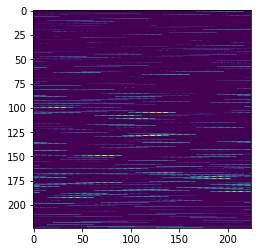

In [57]:
plt.imshow(new_re)

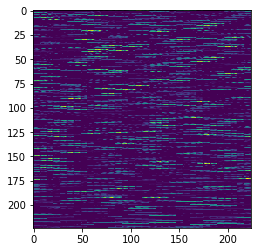

In [58]:
channel_1 = output_np[1,:]
new_re_1 = channel_1.reshape((224,224))
plt.imshow(new_re_1)

In [61]:
print(test_model)

Sequential (
  (0): Sequential (
    (0): _Stem (
      (stem): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (1): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (2): BasicConv2d (
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (3): BasicConv2d (
          (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
        )
        (4): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      )
    )
    (1): _Inception_Module (
      (conv1x1_branch): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(192, 64, kernel_size=(1, 1)

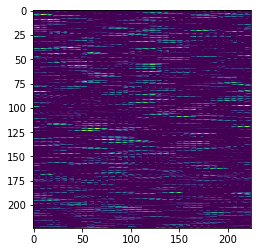

In [62]:
channel_2 = output_np[2,:]
new_re_2 = channel_2.reshape((224,224))
plt.imshow(new_re_2)

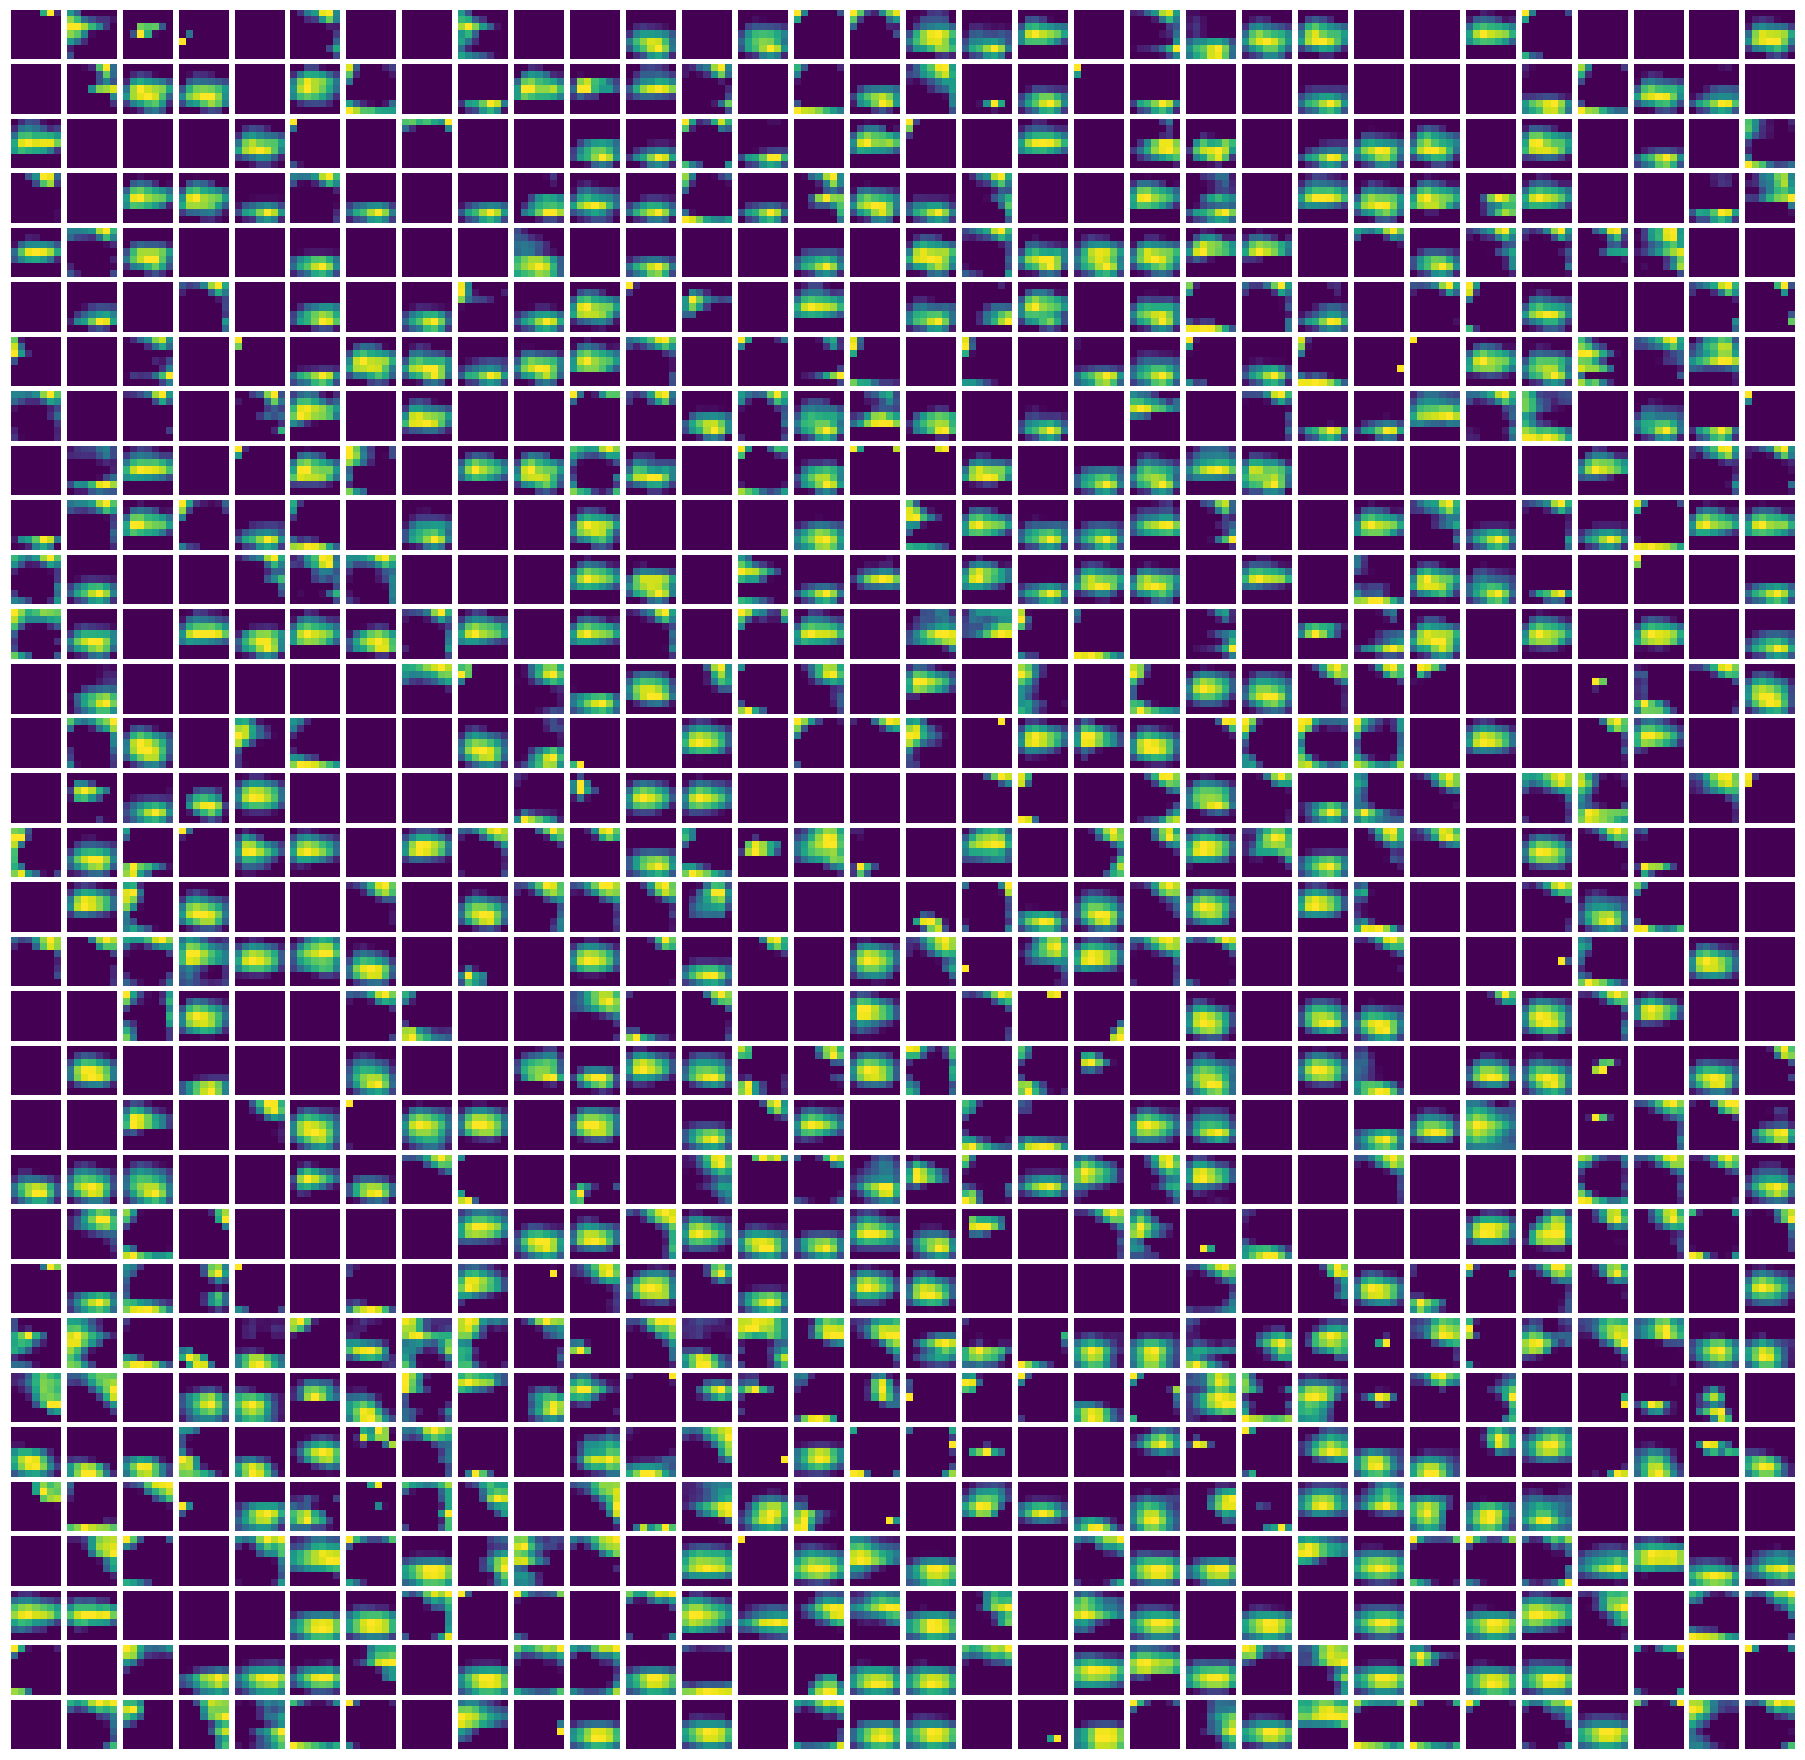

In [66]:
num_kernels = 1024
num_rows = 32
num_cols = 32
fig=plt.figure(figsize=(num_cols,num_rows))
for i in range(1024):
    ax1 = fig.add_subplot(num_rows, num_cols, i+1)
    ax1.imshow(channel_2[i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()

In [67]:
fig.savefig('filter_img.png')

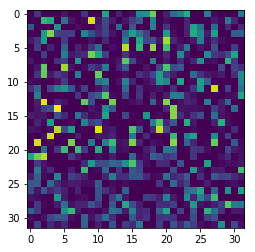

In [97]:
out_2 = new_out_np[2,:]
new_re_2 = out_2.reshape((32,32))
plt.imshow(new_re_2)

In [84]:
test_model_2 = nn.Sequential(*list(best_model.children())[:-1])
for par in test_model_2.parameters():
    par.requires_grad=False


In [85]:
print(test_model_2)

Sequential (
  (0): Sequential (
    (0): _Stem (
      (stem): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (1): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (2): BasicConv2d (
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
        )
        (3): BasicConv2d (
          (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
        )
        (4): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      )
    )
    (1): _Inception_Module (
      (conv1x1_branch): Sequential (
        (0): BasicConv2d (
          (conv): Conv2d(192, 64, kernel_size=(1, 1)

In [92]:
pic_in, label = next(iter(dset_loaders['train']))

In [93]:
pic_in, label = Variable(pic_in.cuda()),Variable(label.cuda())

In [94]:
feature_blobs = []
def hook_feature(module, input, output):
    feature_blobs.append(output.data.cpu().numpy())

In [95]:
best_model._modules.get('features3').register_forward_hook(hook_feature)

In [96]:
best_model._modules.get('features3')

Sequential (
  (0): _Inception_Module (
    (conv1x1_branch): Sequential (
      (0): BasicConv2d (
        (conv): Conv2d(528, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True)
      )
    )
    (conv3x3_branch): Sequential (
      (0): BasicConv2d (
        (conv): Conv2d(528, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True)
      )
      (1): BasicConv2d (
        (conv): Conv2d(160, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True)
      )
    )
    (conv5x5_branch): Sequential (
      (0): BasicConv2d (
        (conv): Conv2d(528, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
      )
      (1): BasicConv2d (
        (conv): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(

In [97]:
params = list(best_model.parameters())

In [98]:
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
print(weight_softmax)
print(weight_softmax.shape)
weight_softmax[0]

[[-0.05780695  0.00065205 -0.04007465 ...,  0.02355446 -0.07951389
  -0.02847968]
 [ 0.00523533  0.00962684  0.02133263 ..., -0.03445009 -0.00107714
  -0.04783633]
 [ 0.02783356  0.02640534  0.01393315 ...,  0.00312033  0.00592024
   0.01698818]
 [-0.02377075 -0.07500827 -0.02961418 ..., -0.04126245  0.00821633
   0.00926084]]
(4, 1024)


array([-0.05780695,  0.00065205, -0.04007465, ...,  0.02355446,
       -0.07951389, -0.02847968], dtype=float32)

In [99]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    #generate the class activation maps upsample to 256*256
    size_upsample = (256,256)
    bz,nc,h,w = feature_conv.shape
    print(bz)
    print(nc)
    print(h)
    print(w)
    output_cam = []
    for num,idx in enumerate(class_idx):
        
        cam = weight_softmax[idx].dot(feature_conv[num].reshape((nc, h*w)))
        cam = cam.reshape(h,w)
        cam = cam - np.min(cam)
        cam_img = cam/np.max(cam)
        cam_img = np.uint8(255*cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [100]:
logit = best_model(pic_in)

In [101]:
print(logit)

Variable containing:
 2.9030 -2.6014 -0.9049 -3.2268
-3.2606  4.6881 -0.8994 -6.5578
-2.1680 -3.5751  4.0726 -5.0389
-4.9435 -4.7065  5.3291 -2.8930
 2.9613 -0.2739 -2.6305 -3.9621
 3.5623 -1.6430 -2.1605 -3.2849
 2.4873 -3.2743 -0.1446 -2.8162
[torch.cuda.FloatTensor of size 7x4 (GPU 0)]



In [102]:
h_x = F.softmax(logit).data.cpu().squeeze()

In [103]:
probs, idx = h_x.sort(1, True)

In [104]:
print(idx)
idx_np = idx.numpy()
print(idx_np)
idx_array = idx_np[:,0]
idx_array = [int(i) for i in idx_array]
print(idx_array)


    0     2     1     3
    1     2     0     3
    2     0     1     3
    2     3     1     0
    0     1     2     3
    0     1     2     3
    0     2     3     1
[torch.LongTensor of size 7x4]

[[0 2 1 3]
 [1 2 0 3]
 [2 0 1 3]
 [2 3 1 0]
 [0 1 2 3]
 [0 1 2 3]
 [0 2 3 1]]
[0, 1, 2, 2, 0, 0, 0]


In [105]:
print(feature_blobs)

[array([[[[  0.00000000e+00,   7.38054188e-03,   3.91151458e-02, ...,
            8.39839131e-02,   0.00000000e+00,   0.00000000e+00],
         [  1.95369720e-02,   1.01617076e-01,   2.29606226e-01, ...,
            1.18253790e-01,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   1.49803013e-01,   2.59090036e-01, ...,
            4.80551235e-02,   0.00000000e+00,   0.00000000e+00],
         ..., 
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00]],

        [[  0.00000000e+00,   0.00000000e+00,   1.07716443e-02, ...,
            3.29282656e-02,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   1.96541667e-01

In [106]:
print(len(feature_blobs[0]))
#print(feature_blobs[0])
print(len(feature_blobs[0][0]))

7
1024


In [107]:
CAMs = returnCAM(feature_blobs[0],weight_softmax,idx_array)

7
1024
7
7


In [108]:
test_pic = pic_in.data.cpu().numpy()

In [109]:
print(test_pic.shape)
print(test_pic[0].shape)

(7, 3, 224, 224)
(3, 224, 224)


In [110]:
print(CAMs)
print(len(CAMs[0]))

[array([[ 25,  25,  25, ...,  55,  55,  55],
       [ 25,  25,  25, ...,  55,  55,  55],
       [ 25,  25,  25, ...,  55,  55,  55],
       ..., 
       [107, 107, 107, ..., 140, 140, 140],
       [107, 107, 107, ..., 140, 140, 140],
       [107, 107, 107, ..., 140, 140, 140]], dtype=uint8), array([[ 47,  47,  47, ...,  91,  91,  91],
       [ 47,  47,  47, ...,  91,  91,  91],
       [ 47,  47,  47, ...,  91,  91,  91],
       ..., 
       [  0,   0,   0, ..., 100, 100, 100],
       [  0,   0,   0, ..., 100, 100, 100],
       [  0,   0,   0, ..., 100, 100, 100]], dtype=uint8), array([[12, 12, 12, ..., 38, 38, 38],
       [12, 12, 12, ..., 38, 38, 38],
       [12, 12, 12, ..., 38, 38, 38],
       ..., 
       [50, 50, 50, ..., 68, 68, 68],
       [50, 50, 50, ..., 68, 68, 68],
       [50, 50, 50, ..., 68, 68, 68]], dtype=uint8), array([[48, 48, 48, ..., 85, 85, 85],
       [48, 48, 48, ..., 85, 85, 85],
       [48, 48, 48, ..., 85, 85, 85],
       ..., 
       [ 0,  0,  0, ...,  5,  5,

In [111]:
test_img = cv2.imread('./mri_imgs/label_0/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.jpg')
test_img_1 = cv2.resize(test_img,(224,224))
print(test_img_1.shape)
cv2.imwrite('test_1.jpg',test_img_1)

(224, 224, 3)


True

In [112]:
height,width,_ = test_img_1.shape

In [113]:
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width,height)), cv2.COLORMAP_JET)

In [114]:
print(heatmap.shape)

(224, 224, 3)


In [115]:
result = heatmap*0.3 + test_img_1*0.5

In [116]:
cv2.imwrite('CAM_with_schiz_cropped.jpg',result)

True